# Multiple-Instance Learning (MIL) for Spectral Data

This notebook implements an attention-based Multiple-Instance Learning (MIL) model for regression on spectral data. Each depth interval (bag) contains multiple spectral instances, and the goal is to predict the interval-level target (TotalREE).

Overview
- Data: VNIR–SWIR spectra with depth metadata
- Approach: Group-aware CV (GroupKFold by depth interval), bag construction, attention-based MIL model, training, and bag-level evaluation
- Interpretation: band importance using attention-weighted gradients and optional permutation tests

How to use
1. Ensure `hullq_interval.csv` exists with `Depth` and `interval` columns (use `add_interval_column.py` if needed).
2. Run cells in order. Keep `RANDOM_STATE` fixed for reproducibility.

Outputs
- Bag-level OOF metrics and plots saved to the repo (e.g., `mil_oof_profile.png`, `mil_oof_scatter.png`)


In [1]:
import json
import numpy as np
import pandas as pd
from typing import List
from sklearn.metrics import r2_score, root_mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [2]:
TARGET_COL = 'TotalREE'
GROUP_COL = 'interval'
DEPTH_COL = 'Depth'

In [3]:
def detect_wavelength_columns(df: pd.DataFrame, exclude: List[str]) -> List[str]:
  """Detect spectral columns: column names that can be converted to float.
  e.g. "350", "350.5", "1412". Excludes columns listed in `exclude`.
  Returns a sorted list of wavelength column names (by numeric value).
  """
  wave_cols = []
  for col in df.columns:
    if col in exclude:
      continue
    try:
      float(col)
      wave_cols.append(col)
    except Exception:
      # not a numeric name -> not a wavelength
      pass
  if not wave_cols:
    raise ValueError(
      "No spectral columns detected. Make sure wavelength columns have numeric names (e.g., '350', '1412')."
    )
  # sort by numeric wavelength value
  wave_cols = sorted(wave_cols, key=lambda c: float(c))
  return wave_cols

In [4]:
data_path = '../data/processed/hullq_interval.csv'
groupkfold_path = '../processing/folds_groupkfold.json'

with open(groupkfold_path, "r", encoding="utf-8") as f:
    folds = json.load(f)

df = pd.read_csv(data_path).sort_values(["interval","Depth"]).reset_index(drop=True)  

# Prepare data
exclude = ['Amostra', 'TotalREE', 'Depth', 'Mask']
feature_cols = detect_wavelength_columns(df, exclude=exclude)   
X = df[feature_cols].values.astype(np.float32)
y = df['TotalREE'].values.astype(np.float32)
groups = df['interval'].values

In [5]:
class SpectralBagDataset(Dataset):
    """Dataset that groups spectral instances into bags by interval/group.

    Each bag returns a tensor of shape (n_instances, n_bands) and a scalar label.
    The label is taken as the first sample's target in the bag (assumes same label per group).
    """
    def __init__(self, X, y, groups):
        self.X = X
        self.y = y
        self.groups = groups
        self.unique_groups = np.unique(groups)

    def __len__(self):
        return int(len(self.unique_groups))

    def __getitem__(self, idx):
        g = self.unique_groups[idx]
        mask = self.groups == g
        # bag: tensor shape (n_instances, n_bands)
        bag = torch.tensor(self.X[mask], dtype=torch.float32)
        # label: scalar (assumes same label for all instances in the bag)
        label = torch.tensor(self.y[mask][0], dtype=torch.float32)
        return bag, label


In [6]:
class AttentionMIL(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        # Embedding network applied per instance
        self.embed = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        # Attention network produces a scalar score per instance
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        # Final regressor from aggregated bag representation
        self.regressor = nn.Linear(hidden_dim, 1)

    def forward(self, bag):
        """Forward pass.

        Args:
            bag: Tensor, shape (n_instances, n_features)
        Returns:
            y_pred: tensor scalar prediction
            att_weights: attention weights tensor shape (n_instances,)
        """
        # Compute embeddings for each instance: (n_instances, hidden_dim)
        H = self.embed(bag)
        # Attention scores and normalized weights
        scores = self.attention(H).squeeze(-1)  # (n_instances,)
        A = torch.softmax(scores, dim=0)
        # Weighted sum to get bag representation
        M = torch.sum(A.unsqueeze(-1) * H, dim=0)  # (hidden_dim,)
        y_pred = self.regressor(M)
        return y_pred.squeeze(), A


In [7]:
def train_epoch(model, loader, optimizer, criterion, device=None):
    """Train for one epoch over bag-level DataLoader."""
    model.train()
    total_loss = 0.0
    n_batches = 0
    for bags, labels in loader:
        optimizer.zero_grad()
        batch_losses = []
        # bags and labels come as lists if collate_fn returns zip; handle both
        if isinstance(bags, list) or isinstance(bags, tuple):
            iterable = zip(bags, labels)
        else:
            iterable = zip(bags, labels)
        for bag, label in iterable:
            if device is not None:
                bag = bag.to(device)
                label = label.to(device)
            y_pred, _ = model(bag)
            loss = criterion(y_pred, label)
            batch_losses.append(loss)
        if len(batch_losses) == 0:
            continue
        batch_loss = torch.stack(batch_losses).mean()
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
        n_batches += 1
    return total_loss / max(1, n_batches)


def eval_epoch(model, loader, device=None):
    """Evaluate model on bag-level DataLoader. Returns (y_true_array, y_pred_array)."""
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for bags, labels in loader:
            if isinstance(bags, list) or isinstance(bags, tuple):
                iterable = zip(bags, labels)
            else:
                iterable = zip(bags, labels)
            for bag, label in iterable:
                if device is not None:
                    bag = bag.to(device)
                pred, _ = model(bag)
                y_true.append(float(label))
                y_pred.append(float(pred))
    return np.array(y_true), np.array(y_pred)



===== Fold 1 =====
Number of samples in X_train: 8893
Number of samples in X_test: 2254
Number of test groups: 14
Epoch 0: train_loss=11.0351
Epoch 5: train_loss=5.5318
Epoch 10: train_loss=2.3763
Epoch 15: train_loss=1.2224
Epoch 20: train_loss=0.7748
Epoch 25: train_loss=0.7225
Epoch 30: train_loss=0.6038
Epoch 35: train_loss=0.6313
Fold 1: R2=0.866, RMSE=0.913


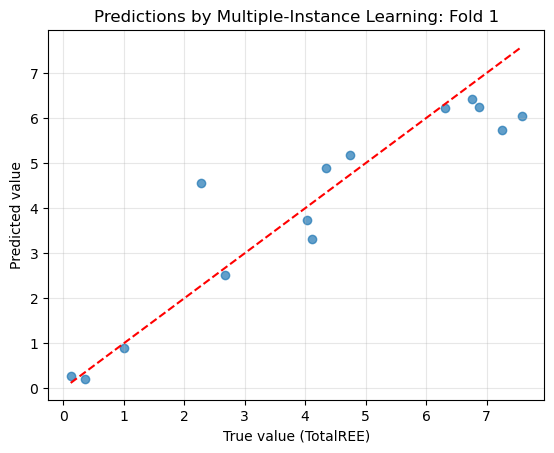


===== Fold 2 =====
Number of samples in X_train: 8918
Number of samples in X_test: 2229
Number of test groups: 14
Epoch 0: train_loss=11.2413
Epoch 5: train_loss=5.2421
Epoch 10: train_loss=1.5568
Epoch 15: train_loss=0.8424
Epoch 20: train_loss=0.8478
Epoch 25: train_loss=0.6166
Epoch 30: train_loss=0.5447
Epoch 35: train_loss=0.5729
Fold 2: R2=0.869, RMSE=0.992


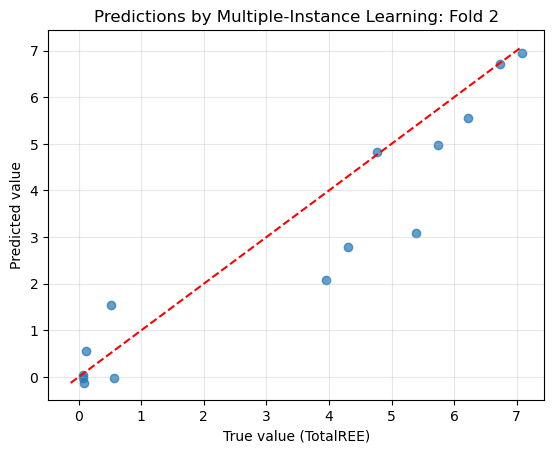


===== Fold 3 =====
Number of samples in X_train: 8916
Number of samples in X_test: 2231
Number of test groups: 14
Epoch 0: train_loss=11.0507
Epoch 5: train_loss=5.0989
Epoch 10: train_loss=2.1228
Epoch 15: train_loss=0.8097
Epoch 20: train_loss=0.7559
Epoch 25: train_loss=0.6099
Epoch 30: train_loss=0.5543
Epoch 35: train_loss=0.7890
Fold 3: R2=0.890, RMSE=0.924


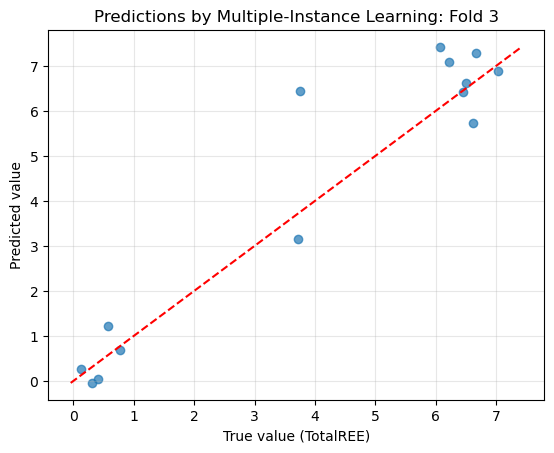


===== Fold 4 =====
Number of samples in X_train: 8892
Number of samples in X_test: 2255
Number of test groups: 14
Epoch 0: train_loss=11.1803
Epoch 5: train_loss=5.3655
Epoch 10: train_loss=1.9761
Epoch 15: train_loss=1.0648
Epoch 20: train_loss=0.9418
Epoch 25: train_loss=0.6674
Epoch 30: train_loss=0.6272
Epoch 35: train_loss=0.5847
Fold 4: R2=0.885, RMSE=0.978


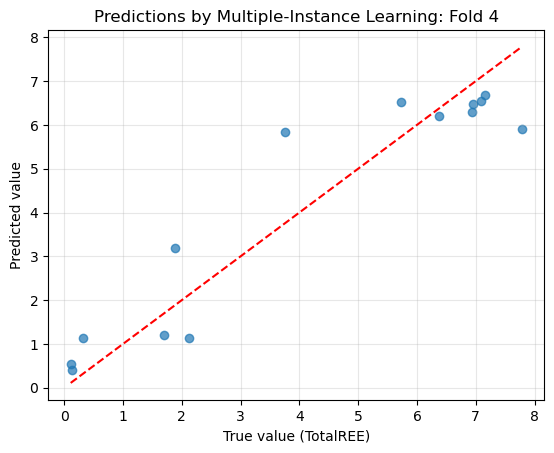


===== Fold 5 =====
Number of samples in X_train: 8969
Number of samples in X_test: 2178
Number of test groups: 13
Epoch 0: train_loss=12.1020
Epoch 5: train_loss=5.0245
Epoch 10: train_loss=1.8361
Epoch 15: train_loss=1.0113
Epoch 20: train_loss=0.9026
Epoch 25: train_loss=0.7468
Epoch 30: train_loss=0.6934
Epoch 35: train_loss=0.6747
Fold 5: R2=0.721, RMSE=1.226


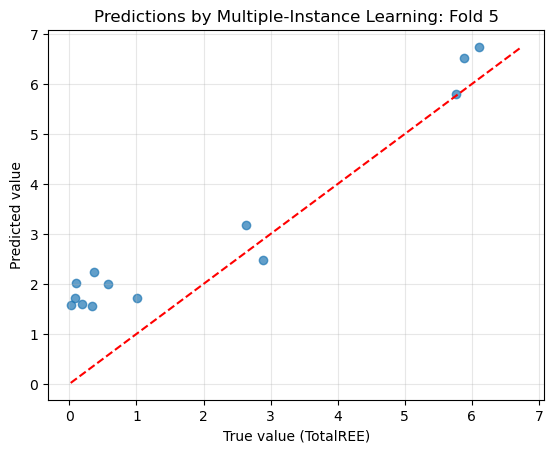

In [8]:
results = []
oof_bag = []  # collect bag-level OOF predictions

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i, fdict in enumerate(folds, 1):
    train_idx = np.array(fdict["train"], dtype=int)
    test_idx = np.array(fdict["test"], dtype=int)
    print(f"\n===== Fold {i} =====")

    # Create datasets and loaders
    train_ds = SpectralBagDataset(X[train_idx], y[train_idx], groups[train_idx])
    test_ds = SpectralBagDataset(X[test_idx], y[test_idx], groups[test_idx])
    print(f"Number of samples in X_train: {len(X[train_idx])}")
    print(f"Number of samples in X_test: {len(X[test_idx])}")
    print(f"Number of test groups: {len(np.unique(groups[test_idx]))}")

    # Collate function returns lists of bags and labels per batch
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=lambda x: list(zip(*x)))
    test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, collate_fn=lambda x: list(zip(*x)))

    # Model, optimizer, criterion
    model = AttentionMIL(input_dim=X.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Training epochs
    n_epochs = 40
    for epoch in range(n_epochs):
        loss = train_epoch(model, train_loader, optimizer, criterion, device=device)
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: train_loss={loss:.4f}")

    # Evaluation on test bags
    y_true, y_pred = eval_epoch(model, test_loader, device=device)
    r2 = r2_score(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    results.append((r2, rmse))
    print(f"Fold {i}: R2={r2:.3f}, RMSE={rmse:.3f}")

    # Collect OOF bag-level predictions
    for g, yt, yp in zip(test_ds.unique_groups, y_true, y_pred):
        oof_bag.append({"group": g, "y_true": float(yt), "y_pred": float(yp)})

    # Optional: quick scatter plot per fold
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.xlabel('True value (TotalREE)')
    plt.ylabel('Predicted value')
    plt.title(f'Predictions by Multiple-Instance Learning: Fold {i}')
    # 1:1 line
    mins = min(min(y_true), min(y_pred))
    maxs = max(max(y_true), max(y_pred))
    plt.plot([mins, maxs], [mins, maxs], 'r--')
    plt.grid(True, alpha=0.3)
    plt.show()

In [9]:
results = np.array(results)
print("\n==== FINAL AVERAGE ====")
print(f"Mean R²: {results[:,0].mean():.3f} ± {results[:,0].std():.3f}")
print(f"Mean RMSE: {results[:,1].mean():.3f} ± {results[:,1].std():.3f}")



==== FINAL AVERAGE ====
Mean R²: 0.846 ± 0.063
Mean RMSE: 1.007 ± 0.114



Average of folds (bag-level): R2=0.846 ± 0.063 | RMSE=1.007 ± 0.114
OOF (bag-level): R2=0.868 | RMSE=1.010


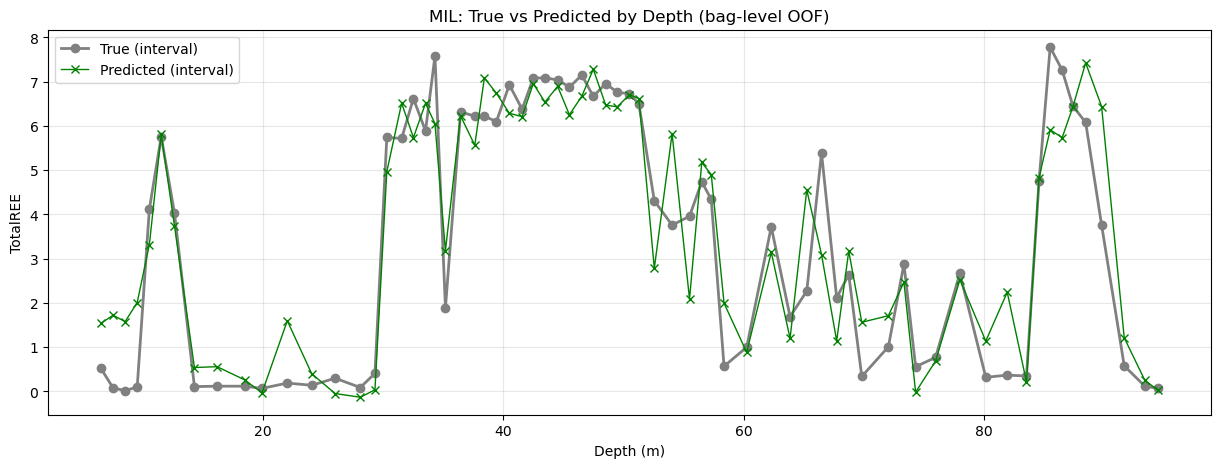

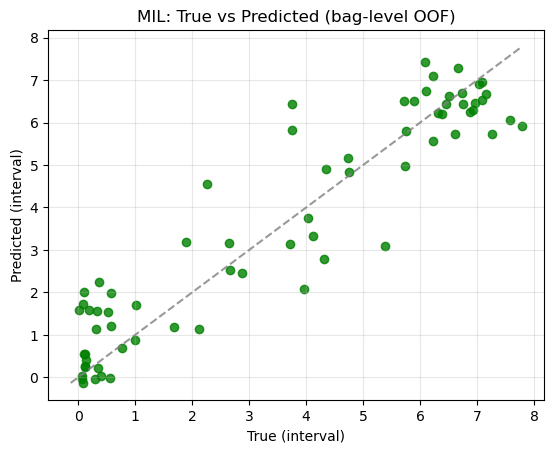

In [10]:
# ==== Aggregate fold metrics (bag-level) ====
fold_metrics = np.array(results)
print(f"\nAverage of folds (bag-level): R2={fold_metrics[:,0].mean():.3f} ± {fold_metrics[:,0].std():.3f} | "
      f"RMSE={fold_metrics[:,1].mean():.3f} ± {fold_metrics[:,1].std():.3f}")

# ==== Global OOF metrics at interval level ====
df_oof = pd.DataFrame(oof_bag)  # columns: group, y_true, y_pred

# Representative depth per interval (median)
depth_per_group = (
    df.groupby(GROUP_COL, as_index=False)[DEPTH_COL]
      .median()
      .rename(columns={DEPTH_COL: "depth_med"})
)

df_oof = df_oof.merge(depth_per_group, left_on="group", right_on=GROUP_COL, how="left")
df_oof = df_oof.drop(columns=[GROUP_COL])

# Global bag-level metrics
r2_bag_global = r2_score(df_oof["y_true"], df_oof["y_pred"])
rmse_bag_global = root_mean_squared_error(df_oof["y_true"], df_oof["y_pred"])
print(f"OOF (bag-level): R2={r2_bag_global:.3f} | RMSE={rmse_bag_global:.3f}")

# ==== Plots by depth (bag-level) ====
df_oof_sorted = df_oof.sort_values("depth_med")

# Profile: true vs predicted by depth
plt.figure(figsize=(15,5))
plt.plot(df_oof_sorted["depth_med"], df_oof_sorted["y_true"], marker='o', label='True (interval)', color='grey', linewidth=2)
plt.plot(df_oof_sorted["depth_med"], df_oof_sorted["y_pred"], marker='x', label='Predicted (interval)', color='green', linewidth=1)
plt.xlabel("Depth (m)")
plt.ylabel("TotalREE")
plt.title("MIL: True vs Predicted by Depth (bag-level OOF)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("mil_oof_profile.png", dpi=300)
plt.show()

# Scatter (bag-level)
plt.figure()
plt.scatter(df_oof["y_true"], df_oof["y_pred"], alpha=0.8, color='green')
lims = [min(df_oof["y_true"].min(), df_oof["y_pred"].min()),
        max(df_oof["y_true"].max(), df_oof["y_pred"].max())]
plt.plot(lims, lims, '--', color='gray', alpha=0.8)
plt.xlabel("True (interval)")
plt.ylabel("Predicted (interval)")
plt.title("MIL: True vs Predicted (bag-level OOF)")
plt.grid(True, alpha=0.3)
plt.savefig("mil_oof_scatter.png", dpi=300)
plt.show()


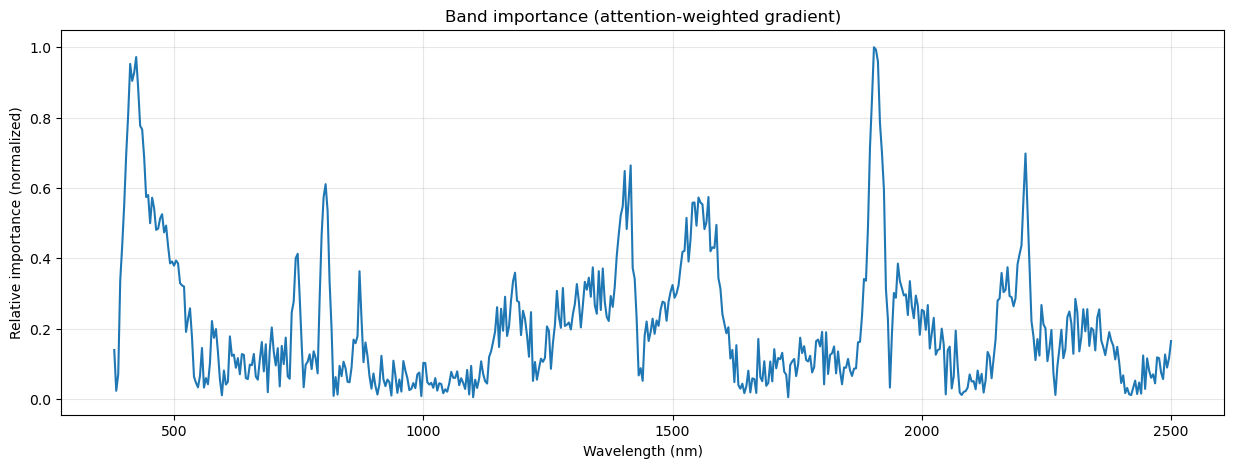

In [11]:
# Band importance via attention-weighted gradient saliency

# Map feature columns to numeric wavelengths
wavelengths = np.array([float(w) for w in feature_cols])

@torch.no_grad()
def _forward_with_attention(model, bag):
    # Utility: forward pass returning prediction and attention weights (no grad)
    pred, A = model(bag)
    return pred, A


def band_saliency_on_bag(model, bag_tensor):
    # Compute |dy/dx| per band aggregated by attention for one bag
    bag = bag_tensor.clone().detach().requires_grad_(True)
    model.zero_grad()
    y_pred, A = model(bag)  # A: (n_inst,)
    y_pred.backward()
    sal = bag.grad.detach().abs()  # (n_inst, n_feat)
    A_norm = torch.softmax(A.detach(), dim=0).unsqueeze(-1)  # (n_inst, 1)
    sal_att = (sal * A_norm).sum(dim=0) / (A_norm.sum())  # (n_feat,)
    return sal_att.cpu().numpy(), y_pred.detach().cpu().item()


def compute_global_band_importance(model, dataset, max_bags=None):
    model.eval()
    imp_list = []
    count = 0
    for idx in range(len(dataset)):
        bag, _ = dataset[idx]
        sal_att, _ = band_saliency_on_bag(model, bag)
        imp_list.append(sal_att)
        count += 1
        if max_bags is not None and count >= max_bags:
            break
    imp = np.stack(imp_list, axis=0).mean(axis=0)
    imp = imp / (imp.max() + 1e-8)
    return imp

# Compute band importance (example on test set of last fold)
band_importance = compute_global_band_importance(model, test_ds)

# Plot band importance by wavelength
plt.figure(figsize=(15, 5))
plt.plot(wavelengths, band_importance)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative importance (normalized)')
plt.title('Band importance (attention-weighted gradient)')
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Print top-20 most important bands
N = 20
top_idx = np.argsort(-band_importance)[:N]
print("Top-20 most important bands:")
for rank, i in enumerate(top_idx, 1):
    print(f"{rank:2d}. {int(wavelengths[i])} nm | score={band_importance[i]:.3f}")

Top-20 most important bands:
 1. 1904 nm | score=1.000
 2. 1908 nm | score=0.993
 3. 424 nm | score=0.972
 4. 1912 nm | score=0.959
 5. 412 nm | score=0.953
 6. 420 nm | score=0.928
 7. 416 nm | score=0.904
 8. 428 nm | score=0.883
 9. 1900 nm | score=0.851
10. 408 nm | score=0.811
11. 1916 nm | score=0.786
12. 432 nm | score=0.777
13. 436 nm | score=0.766
14. 1896 nm | score=0.714
15. 1920 nm | score=0.701
16. 2208 nm | score=0.698
17. 404 nm | score=0.696
18. 440 nm | score=0.687
19. 1416 nm | score=0.664
20. 1404 nm | score=0.648


In [13]:
# ==== Band importance via permutation importance ====
def permutation_band_importance(model, dataset, band_indices, n_bags=20):
  rng = np.random.default_rng(42)
  model.eval()
  # Seleciona subconjunto de bags
  idxs = rng.choice(len(dataset), size=min(n_bags, len(dataset)), replace=False)
  # baseline
  y_true, y_pred = [], []
  with torch.no_grad():
    for idx in idxs:
      bag, label = dataset[idx]
      pred, _ = model(bag)
      y_true.append(label.item())
      y_pred.append(pred.item())
  base_rmse = root_mean_squared_error(y_true, y_pred)


  drops = []
  for b in band_indices:
    y_pred_perm = []
    for idx in idxs:
      bag, label = dataset[idx]
      bag_perm = bag.clone()
      # permuta a coluna b ao longo das instâncias do bag
      perm = torch.randperm(bag_perm.size(0))
      bag_perm[:, b] = bag_perm[perm, b]
      with torch.no_grad():
        pred, _ = model(bag_perm)
        y_pred_perm.append(pred.item())
    rmse_perm = root_mean_squared_error(y_true, y_pred_perm)
    drops.append(rmse_perm - base_rmse)
  return np.array(drops), base_rmse


# Example: quickly validate top-10 bands by permutation method
subset_bands = top_idx[:10]
drops, base_rmse = permutation_band_importance(model, test_ds, subset_bands, n_bags=20)
print(f"RMSE baseline (subset perm): {base_rmse:.3f}")
for i, d in zip(subset_bands, drops):
  print(f"ΔRMSE when permuting {int(wavelengths[i])} nm: +{d:.3f}")

RMSE baseline (subset perm): 1.226
ΔRMSE when permuting 1904 nm: +-0.001
ΔRMSE when permuting 1908 nm: +-0.001
ΔRMSE when permuting 424 nm: +-0.005
ΔRMSE when permuting 1912 nm: +-0.001
ΔRMSE when permuting 412 nm: +-0.005
ΔRMSE when permuting 420 nm: +-0.005
ΔRMSE when permuting 416 nm: +-0.006
ΔRMSE when permuting 428 nm: +-0.004
ΔRMSE when permuting 1900 nm: +-0.001
ΔRMSE when permuting 408 nm: +-0.004


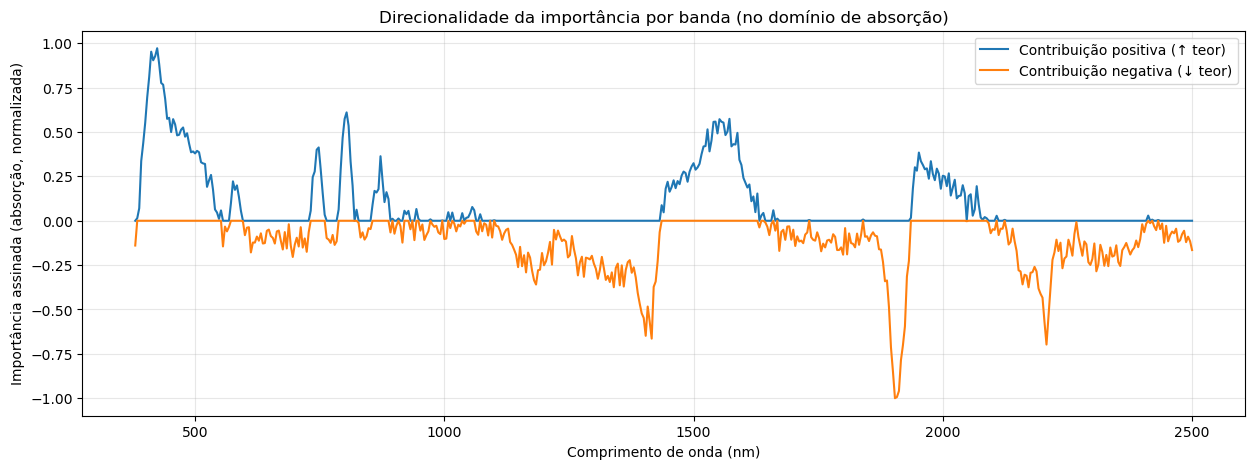

Top POSITIVE bands (↑ content):
 1. 424 nm | score=+0.972
 2. 412 nm | score=+0.953
 3. 420 nm | score=+0.928
 4. 416 nm | score=+0.904
 5. 428 nm | score=+0.883
 6. 408 nm | score=+0.811
 7. 432 nm | score=+0.777
 8. 436 nm | score=+0.766
 9. 404 nm | score=+0.696
10. 440 nm | score=+0.687
11. 804 nm | score=+0.611
12. 448 nm | score=+0.580
13. 444 nm | score=+0.574
14. 1572 nm | score=+0.574
15. 800 nm | score=+0.574
Top NEGATIVE bands (↓ content):
 1. 1904 nm | score=-1.000
 2. 1908 nm | score=-0.993
 3. 1912 nm | score=-0.959
 4. 1900 nm | score=-0.851
 5. 1916 nm | score=-0.786
 6. 1896 nm | score=-0.714
 7. 1920 nm | score=-0.701
 8. 2208 nm | score=-0.698
 9. 1416 nm | score=-0.664
10. 1404 nm | score=-0.648
11. 1924 nm | score=-0.595
12. 2204 nm | score=-0.571
13. 1412 nm | score=-0.569
14. 1400 nm | score=-0.548
15. 2212 nm | score=-0.540


In [14]:
# ==== Band importance with SIGN (directionality) via attention-weighted gradient saliency ====

def _safe_len_dataset(dataset):
  # covers cases where len(dataset) is not properly defined
  try:
    return len(dataset)
  except TypeError:
    if hasattr(dataset, 'unique_groups'):
      return int(len(dataset.unique_groups))
  raise

def band_signed_saliency_on_bag(model, bag_tensor):
    bag = bag_tensor.clone().detach().requires_grad_(True)
    model.zero_grad()
    y_pred, A = model(bag)
    y_pred.backward()
    # saliency with sign (gradient): dy/dx
    sal = bag.grad.detach()  # (n_inst, n_feat), can be positive/negative
    A_norm = torch.softmax(A.detach(), dim=0).unsqueeze(-1)
    sal_att_signed = (sal * A_norm).sum(dim=0) / A_norm.sum()  # (n_feat,)
    return sal_att_signed.cpu().numpy(), y_pred.detach().cpu().item()


def compute_global_signed_importance(model, dataset, max_bags=None):
    model.eval()
    signed_list = []
    count = 0
    total = _safe_len_dataset(dataset)
    for idx in range(total):
        bag, _ = dataset[idx]
        sal_signed, _ = band_signed_saliency_on_bag(model, bag)
        signed_list.append(sal_signed)
        count += 1
        if max_bags is not None and count >= max_bags:
            break
    signed_imp = np.stack(signed_list, axis=0).mean(axis=0)
    # normalize by max absolute magnitude to compare signs
    signed_imp = signed_imp / (np.max(np.abs(signed_imp)) + 1e-8)
    return signed_imp

# Signed importance (relative to REFLECTANCE)
band_importance_signed = compute_global_signed_importance(model, test_ds)

# To interpret in the ABSORPTION domain (~ 1 - R), we invert the sign:
band_importance_signed_abs = -band_importance_signed

# Separate positive (↑ content) and negative (↓ content) components
pos_imp = np.clip(band_importance_signed_abs, 0, None)
neg_imp = np.clip(band_importance_signed_abs, None, 0)

# Plot positive/negative curves
plt.figure(figsize=(15,5))
plt.plot(wavelengths, pos_imp, label='Contribuição positiva (↑ teor)')
plt.plot(wavelengths, neg_imp, label='Contribuição negativa (↓ teor)')
plt.xlabel('Comprimento de onda (nm)')
plt.ylabel('Importância assinada (absorção, normalizada)')
plt.title('Direcionalidade da importância por banda (no domínio de absorção)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Top-K listings
K = 15
pos_idx = np.argsort(-pos_imp)[:K]
neg_idx = np.argsort(neg_imp)[:K]  # most negative (lowest values)

print('Top POSITIVE bands (↑ content):')
for rank, i in enumerate(pos_idx, 1):
    print(f"{rank:2d}. {int(wavelengths[i])} nm | score=+{pos_imp[i]:.3f}")

print('Top NEGATIVE bands (↓ content):')
for rank, i in enumerate(neg_idx, 1):
    print(f"{rank:2d}. {int(wavelengths[i])} nm | score={neg_imp[i]:.3f}")


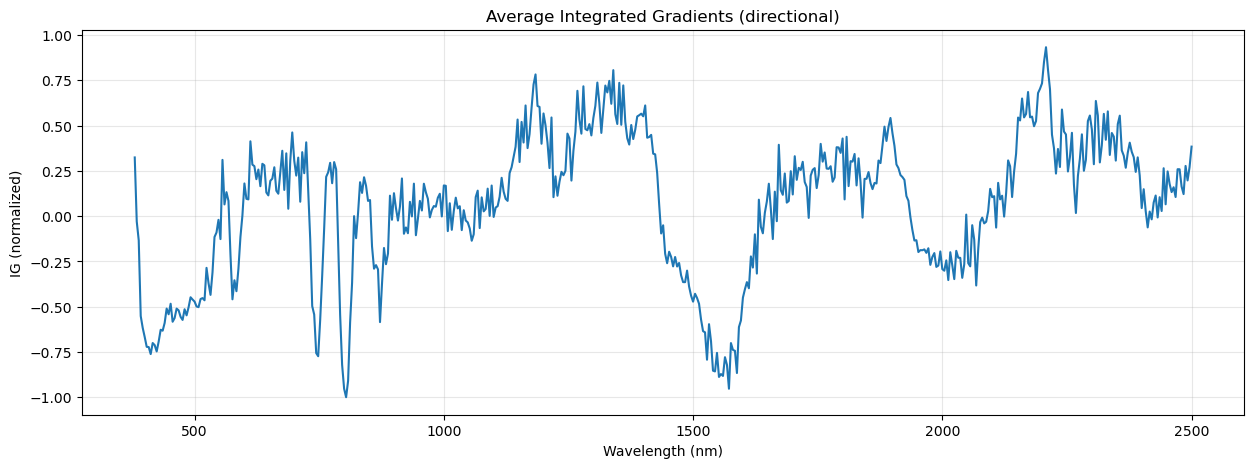

In [15]:
# ==== Integrated Gradients for band importance (directional) ====

def integrated_gradients_on_bag(model, bag_tensor, steps=32, baseline=None):
    model.eval()
    x = bag_tensor.detach()
    if baseline is None:
        baseline = torch.zeros_like(x)
    scaled_inputs = [baseline + (float(t)/steps) * (x - baseline) for t in range(1, steps+1)]

    ig_sum = torch.zeros_like(x)
    for xi in scaled_inputs:
        xi = xi.clone().detach().requires_grad_(True)
        model.zero_grad()
        y_pred, A = model(xi)
        y_pred.backward()
        grad = xi.grad.detach()
        A_norm = torch.softmax(A.detach(), dim=0).unsqueeze(-1)
        ig_sum += grad * A_norm

    ig = (x - baseline) * ig_sum / steps
    # Agrega instâncias para nível de banda
    ig_band = ig.sum(dim=0) / (torch.sum(torch.softmax(model(bag_tensor)[1].detach(), dim=0)) + 1e-8)
    return ig_band.cpu().numpy()

# Compute Integrated Gradients importance (example on test set of last fold)
idxs = np.random.default_rng(0).choice(_safe_len_dataset(test_ds), size=min(10, _safe_len_dataset(test_ds)), replace=False)
ig_list = []
for i in idxs:
    bag, _ = test_ds[i]
    ig_list.append(integrated_gradients_on_bag(model, bag, steps=32))
ig_mean = np.mean(np.stack(ig_list), axis=0)
ig_mean = ig_mean / (np.max(np.abs(ig_mean)) + 1e-8)
plt.figure(figsize=(15,5))
plt.plot(wavelengths, ig_mean)
plt.xlabel('Wavelength (nm)')
plt.ylabel('IG (normalized)')
plt.title('Average Integrated Gradients (directional)')
plt.grid(True, alpha=0.3)
plt.show()
